In [1]:
from utils import keys_to_counts, get_keys

In [2]:
import pandas as pd

data_path = "D:\\studium\\analyse\\data_prep\\src\\_2_preproc_pipeline_de\\data_preprocessed\\2_tokenize.csv"
df = pd.read_csv(data_path)

In [3]:
df.head()

,id,pub_year,text_preproc2
0,DE102018121415B4,2024,hohl handgelenkelement umfassend hohl handgele...
1,DE102022128419B4,2024,wellgetrieb wellgetriebe erfindung betreffen w...
2,DE102016012333B4,2024,robotersystem vielzahl vernetzt controllern ro...
3,DE102020135010B4,2024,massedat schätzung extern last robotermanipula...
4,DE102021104544B4,2024,fügesystem robotergeführt fügeprozessgerät zug...


In [4]:
# vectorize the text data with tf-idf
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer(min_df=10, max_df=0.9)

x_vec = vectorizer.fit_transform(df['text_preproc2'])

In [5]:
vectorizer.get_feature_names_out().__len__()

972

In [6]:
"roboter" in set(vectorizer.get_feature_names_out())

False

In [13]:
# Define Search Param
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.model_selection import GridSearchCV


search_params = {
    'n_components': list([6, 8]),
    'learning_decay': [i/10 for i in range(2, 8, 2)]
}
# Init the Model
lda = LatentDirichletAllocation(max_iter=5, learning_method='online', learning_offset=50., random_state=0)
# Init Grid Search Class
model = GridSearchCV(lda, param_grid=search_params)
# Do the Grid Search
model.fit(x_vec)

GridSearchCV(estimator=LatentDirichletAllocation(learning_method='online',
                                                 learning_offset=50.0,
                                                 max_iter=5, random_state=0),
             param_grid={'learning_decay': [0.2, 0.4, 0.6],
                         'n_components': [6, 8]})

In [14]:
# Best Model
best_lda_model = model.best_estimator_
# Model Parameters
print("Best Model's Params: ", model.best_params_)
# Log Likelihood Score
print("Best Log Likelihood Score: ", model.best_score_)
# Perplexity
print("Model Perplexity: ", best_lda_model.perplexity(x_vec))

Best Model's Params:  {'learning_decay': 0.4, 'n_components': 6}
Best Log Likelihood Score:  -82757.3218719993
Model Perplexity:  450.03785094445027


#### 1
```
Best Model's Params:  {'learning_decay': 0.7, 'n_components': 4}
Best Log Likelihood Score:  -16133.781235803111
Model Perplexity:  2756.7305690617686
```

#### 2
```
Best Model's Params:  {'learning_decay': 0.7, 'n_components': 4}
Best Log Likelihood Score:  -13680.405833094293
Model Perplexity:  1452.4892164519924

tfidf = TfidfVectorizer(min_df=10, max_df=0.9)
```

#### 3
```
Best Model's Params:  {'learning_decay': 0.5, 'n_components': 4}
Best Log Likelihood Score:  -81158.2175760758
Model Perplexity:  436.3635163522717

tfidf = CountVec(min_df=10, max_df=0.9)
```

#### 4
```
Best Model's Params:  {'learning_decay': 0.4, 'n_components': 6}
Best Log Likelihood Score:  -82757.3218719993
Model Perplexity:  450.03785094445027

tfidf = CountVec(min_df=10, max_df=0.9)
```


In [15]:
lda_output = best_lda_model.transform(x_vec)

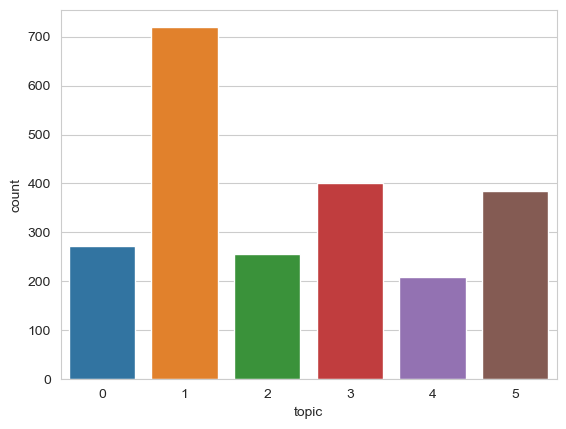

In [16]:
import seaborn as sns
import matplotlib.pyplot as plt

lda_keys = get_keys(lda_output)
lda_categories, lda_counts = keys_to_counts(lda_keys)

topics_df_lda = pd.DataFrame({'topic' : lda_categories, 'count' : lda_counts})
sns.barplot(x=topics_df_lda['topic'], y = topics_df_lda['count'])
plt.show()

In [17]:
import numpy as np

# Show top n keywords for each topic
def show_topics(vectorizer, lda_model, n_words=10):
    keywords = np.array(vectorizer.get_feature_names_out())
    topic_keywords = []
    for topic_weights in lda_model.components_:
        top_keyword_locs = (-topic_weights).argsort()[:n_words]
        topic_keywords.append(keywords.take(top_keyword_locs))
    return topic_keywords
topic_keywords = show_topics(vectorizer=vectorizer, lda_model=best_lda_model, n_words=15)
# Topic - Keywords Dataframe
df_topic_keywords = pd.DataFrame(topic_keywords)
df_topic_keywords.columns = ['Word '+str(i) for i in range(df_topic_keywords.shape[1])]
df_topic_keywords.index = ['Topic '+str(i) for i in range(df_topic_keywords.shape[0])]
df_topic_keywords

,Word 0,Word 1,Word 2,Word 3,Word 4,Word 5,Word 6,Word 7,Word 8,Word 9,Word 10,Word 11,Word 12,Word 13,Word 14
Topic 0,werkstück,verfahren,umfassen,greifer,abschnitt,automatisch,erfindung,oberfläche,hand,greifen,artikel,aufweisen,umfassend,schweißbrenner,transportieren
Topic 1,aufweisen,erfindung,betreffen,ausbilden,roboterarm,anordnen,vorrichtung,bauteil,umfassen,richtung,gehäuse,umfassend,verbinden,arm,reinigungsroboter
Topic 2,basis,position,berechnen,erzeugen,datum,mehrzahl,pose,verfahren,steuervorrichtung,erfassen,speichern,umfassen,signal,robotisch,kraft
Topic 3,verfahren,mobil,erfindung,betreffen,system,mehrere,ermitteln,schritt,autonom,aufweisen,fahrzeug,vorrichtung,robotervorrichtung,vorgegeben,bestimmen
Topic 4,konfigurieren,umfassen,robotersystem,mehrere,verbinden,achse,gelenk,roboterarm,beweglich,vielzahl,elektrisch,basis,steuerung,beinhalten,bewegen
Topic 5,objekt,bild,position,sensor,kamera,robotermanipulator,bestimmen,steuereinheit,erfassen,basierend,erzeugen,robotersystem,dreidimensional,vielzahl,information


In [18]:
#this is by far the easiest way to load a pre-trained sklearn lda model onto pyLDAvis
#there are other means of using this visible on pyLDAvis' main repo

import pyLDAvis
import pyLDAvis.sklearn
pyLDAvis.enable_notebook()

feature_names = vectorizer.get_feature_names_out()

vectorizer.get_feature_names = lambda: feature_names

display_data = pyLDAvis.sklearn.prepare(best_lda_model, #our pre-trained LDA model
                         x_vec, #this gives us our document-term matrix
                        vectorizer) #the vectoriser object
                        
pyLDAvis.display(display_data)  

C:\Users\paul-\anaconda3\envs\ml_angew_programm\lib\site-packages\pyLDAvis\_prepare.py:243: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  default_term_info = default_term_info.sort_values(
